In [463]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

# General Remarks
- If you want to run the notebook please be sure you first run the cells in the "Annexes" part (tout en bas.       

# One word about methodology

In order to give an accuracy of a model on a given dataset we proceed by **cross validation** on the entire dataset: we compute the loss on 40% of the dataset selected randomly several times. We do not proceed by selecting train and test data beforehand.

# Part One: Different Models on Dummy Datasets

# KNN
## 1) Implementation

In [505]:
# L2 norm KNN implem
class myKNN:
    
    def __init__(self, k):
        self._k = k
        self._data = np.empty((0,))
        return
    
    # data must be a np matrix
    # Of shape n_examples * (n_features+1)
    # With:
    #      -data[i][:-1] = features
    #      -data[i][-1] = label
    def learn(self, data, p=True, distro=None):
        self._data = np.copy(data)
        if p:
            print("Done")
        
    # computes k-NN majority
    # for one query vector
    # and L2 norm
    def predict_one(self, query_vec):
        distances = np.linalg.norm(self._data[:,:-1]-query_vec,axis=1)
        kNNs = distances.argsort()[:self._k]
        closest_labels = (self._data[:,-1:].squeeze())[kNNs].astype(int)
        # We resolve ties by taking
        # the smallest class among winners
        return np.argmax(np.bincount(closest_labels))
        
    # to_predict must be a np matrix
    # Of shape n_examples * n_features
    # Whith one feature vec by example
    def predict(self, to_predict):
        result = []
        for query in to_predict:
            result.append(self.predict_one(query))
        return np.array(result)
    
    # for plotting purpose
    def name(self):
        return "KNN with k="+str(self._k)

## 2) Tests
### a) Moons dataset
We show the decision boundaries for different k's with **cross-valid** score in the down right corner.

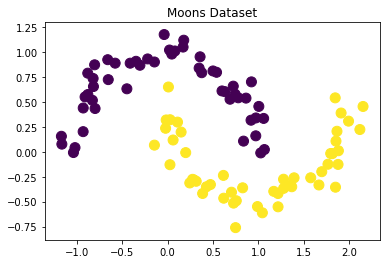

In [330]:
# Dataset gen
X_moons, y_moons = make_moons(noise = 0.1, random_state=1)
plt.title("Moons Dataset")
plt.scatter(X_moons[:,0],X_moons[:,1], c = y_moons, s = 100)
plt.show()

In [339]:
# Training KNN for different k
# And computing cross-valid scores
KNN_clf_moons = [(myKNN(k),0.0) for k in range(1,101,9)]
data_moons = np.c_[X_moons,y_moons]
for (i,(model,_)) in enumerate(KNN_clf_moons):
    score = cross_valid_score(model,data_moons)
    model.learn(data_moons,p=False)
    KNN_clf_moons[i] = (model, score)

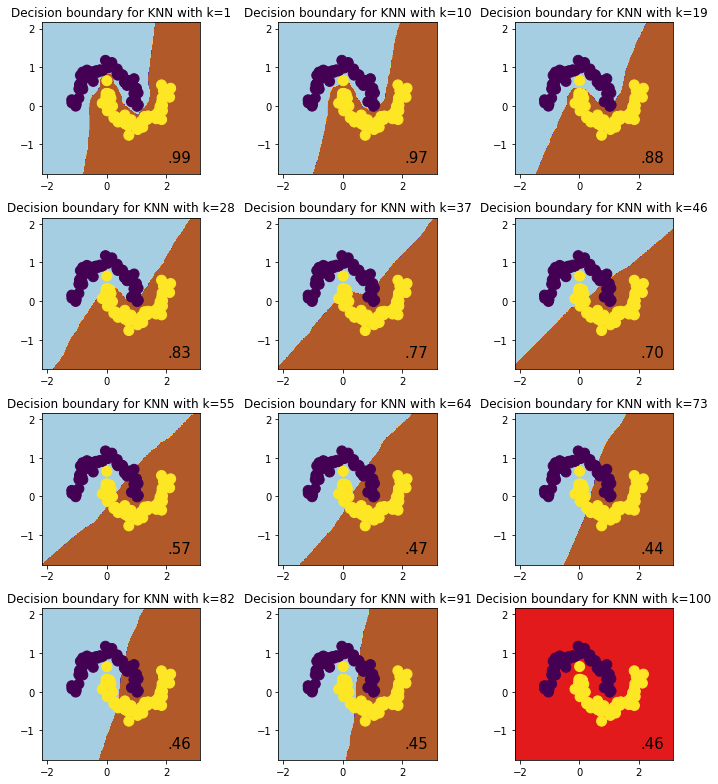

In [332]:
# Showing the results (with cross valid score in down left)
plt.figure(figsize=(10,11))
for (i,(model,score)) in enumerate(KNN_clf_moons):
    ax = plt.subplot(len(KNN_clf_moons)/3, 3, i+1)
    plot_frontiere(model, X_moons, y_moons, ax, score)
plt.tight_layout()
plt.show()

### Commentaries   
-We see that with k increasing we underfit.    
-But as we use **cross validation**, the 99% for k=1 **is not** a sign of over fitting, it is just a very good model for that dataset.

### b) Circles

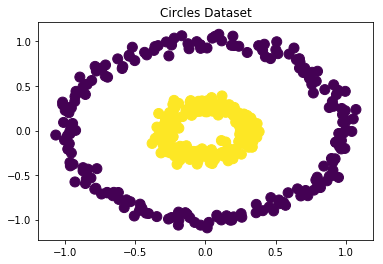

In [334]:
X_circles, y_circles = make_circles(n_samples=400, factor=.3, noise=.05)
plt.title("Circles Dataset")
plt.scatter(X_circles[:,0],X_circles[:,1], c = y_circles, s = 100)
plt.show()

In [357]:
# Training KNN for different k
# And computing cross-valid scores
KNN_clf_circles = [(myKNN(k),0.0) for k in range(1,201,2*9)]
data_circles = np.c_[X_circles,y_circles]
for (i,(model,_)) in enumerate(KNN_clf_circles):
    score = cross_valid_score(model,data_circles)
    model.learn(data_circles,p=False)
    KNN_clf_circles[i] = (model, score)

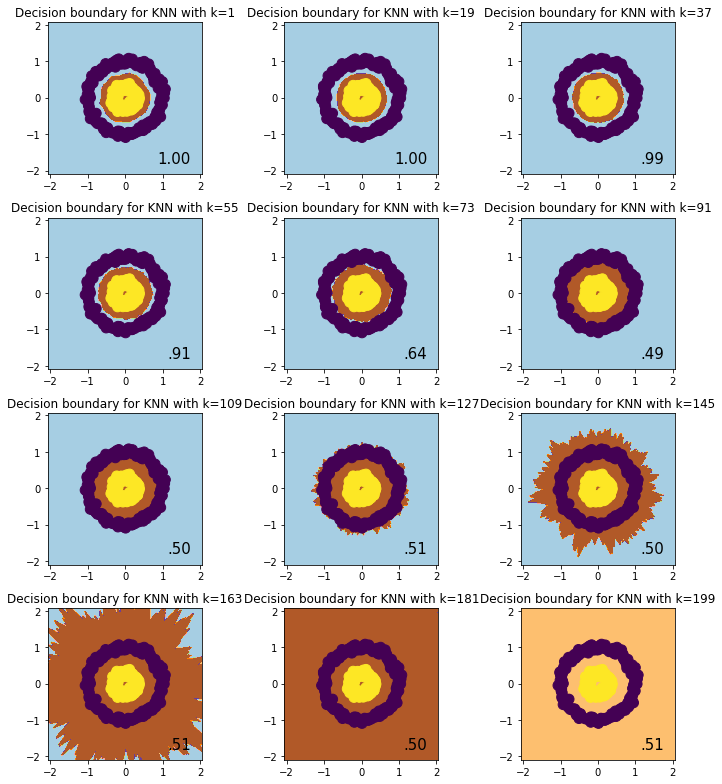

In [359]:
# Showing the results (with cross valid score in down left)
plt.figure(figsize=(10,11))
for (i,(model,score)) in enumerate(KNN_clf_circles):
    ax = plt.subplot(len(KNN_clf_circles)/3, 3, i+1)
    plot_frontiere(model, X_circles, y_circles, ax, score)
plt.tight_layout()
plt.show()

### Commentaries
-Again k=1 gives a really good cross-validated model.       
-We see that the decision boundary exploses quickly (k=145), and taking k to big make everybody fall in the same class the choice becomes as random (because as many points in each ring).        
-Weak learners for this dataset should be seeked between k=70 and k=100 I think.

### c) Make Classification: Two Informative Features, Two Clusters/Class

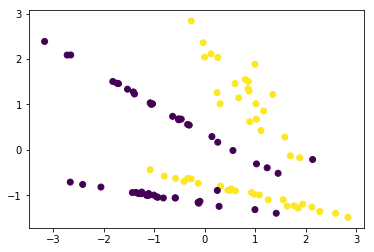

In [345]:
X2, Y2 = make_classification(n_features=2, n_redundant=0, n_informative=2)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2)
plt.show()

In [349]:
# Training KNN for different k
# And computing cross-valid scores
KNN_clf_2 = [(myKNN(k),0.0) for k in range(1,13)]
data_2 = np.c_[X2,Y2]
for (i,(model,_)) in enumerate(KNN_clf_2):
    score = cross_valid_score(model,data_2)
    model.learn(data_2,p=False)
    KNN_clf_2[i] = (model, score)

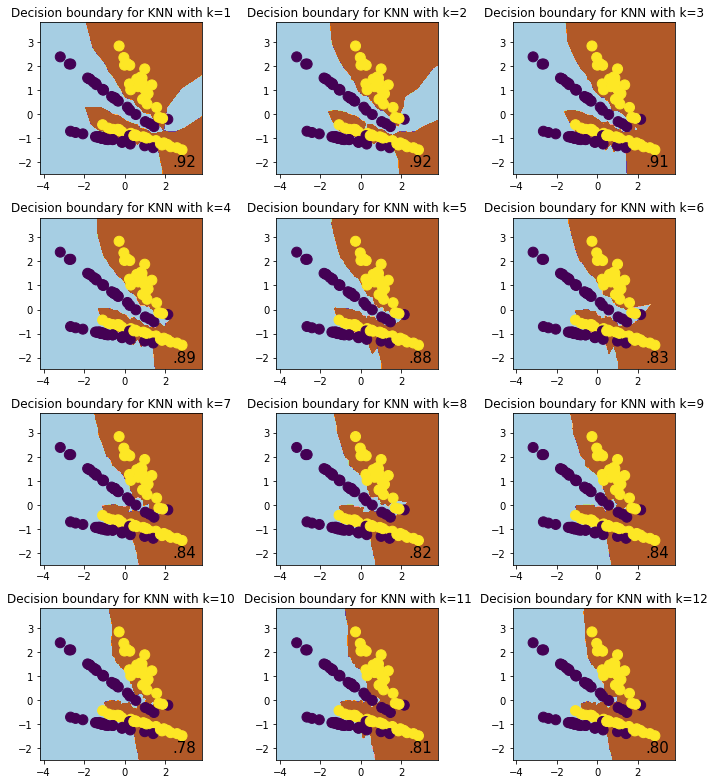

In [350]:
# Showing the results (with cross valid score in down left)
plt.figure(figsize=(10,11))
for (i,(model,score)) in enumerate(KNN_clf_2):
    ax = plt.subplot(len(KNN_clf_2)/3, 3, i+1)
    plot_frontiere(model, X2, Y2, ax, score)
plt.tight_layout()
plt.show()

### Commentaries
We show results for small k where we have hope to do better than k=1 at cross-valid, we have that k=2 is sensibly equivalent.

### c) Make Classification: Three Classes, Two Informative Features, One Clusters/Class

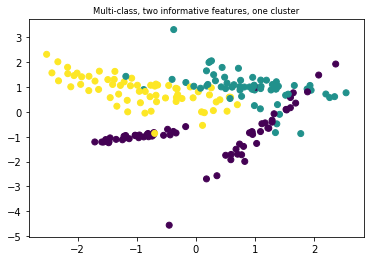

In [352]:
plt.title("Multi-class, two informative features, one cluster",
          fontsize='small')
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=3)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1)
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=3)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1)
plt.show()

In [355]:
# Training KNN for different k
# And computing cross-valid scores
KNN_clf_1 = [(myKNN(k),0.0) for k in range(1,3*6+1)]
data_1 = np.c_[X1,Y1]
for (i,(model,_)) in enumerate(KNN_clf_1):
    score = cross_valid_score(model,data_1)
    model.learn(data_1,p=False)
    KNN_clf_1[i] = (model, score)

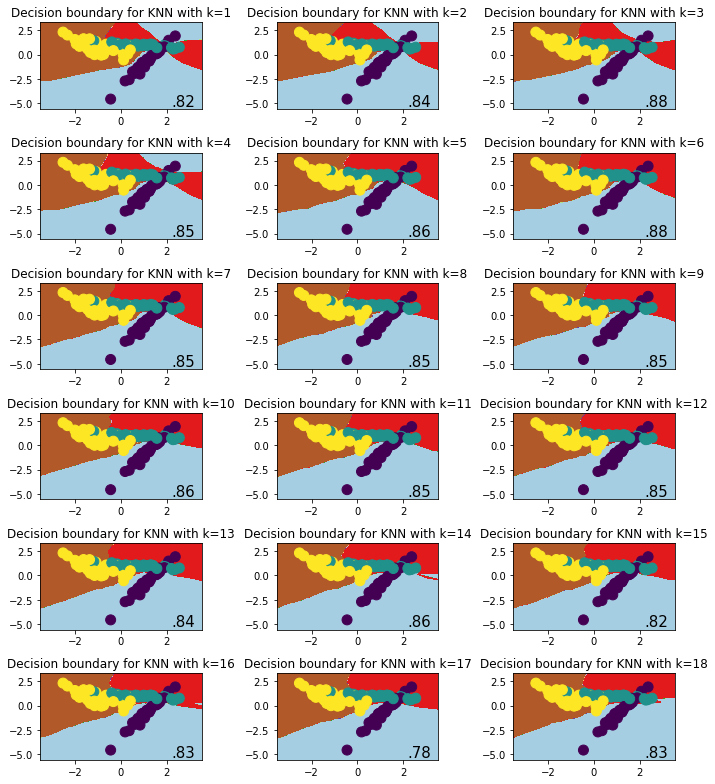

In [356]:
# Showing the results (with cross valid score in down left)
plt.figure(figsize=(10,11))
for (i,(model,score)) in enumerate(KNN_clf_1):
    ax = plt.subplot(len(KNN_clf_1)/3, 3, i+1)
    plot_frontiere(model, X1, Y1, ax, score)
plt.tight_layout()
plt.show()

### Commentaries
-First **different results** from the begining k=1 is not the best for cross valid.    
-k=4 seems to be the best model with regards to decision boundaries but k=6 for cross valid.     
-The cross valid score becomes unstable, it is not as monotone as before.

# Adaboost
## 1) Implementation
We implement our own adaboost with also our own Decision Stump (in 2D only). We will compare it to what sklearn does.    
### A)Decision Stump  (Binary Classif)   
Given a distribution $D = D_{+} \cup D_{-}$ on our set of 2D points we want to find a line of equation $x = C$ or $y = C$ such as the mean of the entropies on both sides of the line is minimal.    
The entropy for a set of point lying in a half plane $P$ is define as:    
$$ H_2(\frac{\sum_{i \in P, i \in D_{+}}D_{i}}{\sum_{i \in P} D_{i}})$$    
With $H_2(p) = -plog_{2}(p)-(1-p)log_{2}(1-p)$      
    
Once we have such a separation the decision rule is as follow: we take the half space that minimizes the entropy among the two and take the most probable answer for this half space. We take the opposite for the other.      
      
We can find such the optimal halfspace in log*linear time by enumerating points in their $x$ order and then in their $y$ order.    
However, we do it in $n^2$ because it goes quicker to implement.

In [552]:
class myStump:
    
    def __init__(self):
        self._data = np.empty((0,))
        
        # The decision is encoded as follows:
        #     -self._decision[0]: 0 si cut en x, 1 si en y
        #     -self._decision[1]: le x ou y frontière
        #     -self._decision[2]: 0 si la classe 0 est du cote <=
        self._decision = [0,0,0]
        return
    
    # data must be a np matrix
    # Of shape n_examples * (n_features+1)
    # With:
    #      -data[i][:-1] = features
    #      -data[i][-1] = label
    # Distro is a np vector giving
    # a probability distribution on
    # examples (for adaboost)
    def learn(self, data, distro, p=False):
        self._data = np.copy(data)
        indexes = np.array(range(len(data)))
        self._data = np.c_[self._data,indexes]
        
        min_entropy = 2.0#unreachable
        
        for direction in range(2):
            order = self._data[:,direction].argsort()
            last_point = self._data[order][0]
            for (i,point) in enumerate(self._data[order][1:]):
                if point[direction] == last_point[direction]:
                    continue
                
                left_side = self._data[order][:i+1]
                right_side = self._data[order][i+1:]
                
                curr_decision = (point[direction]+last_point[direction])/2
                
                if p:
                    dir_s = "x" if direction == 0 else "y"
                    print("Cut "+dir_s+"="+str(curr_decision))
                
                curr_entropy,label_left = self.mean_entropy(left_side,right_side, distro)
                
                if p:
                    print("Curr_entropy:", curr_entropy)
                
                if curr_entropy < min_entropy:
                    min_entropy = curr_entropy
                    self._decision = [direction,curr_decision,label_left]
                last_point = point
    
    # computes stump decision
    # for one query vector
    def predict_one(self, query_vec):
        if query_vec[self._decision[0]] <= self._decision[1]:
            return self._decision[2]
        return 1 - self._decision[2]
        
    # to_predict must be a np matrix
    # Of shape n_examples * n_features
    # Whith one feature vec by example
    def predict(self, to_predict):
        result = []
        for query in to_predict:
            result.append(self.predict_one(query))
        return np.array(result)
    
    # The following make the entropy based calculations
    def h2(self, p):
        if p == 0.0 or p == 1.0:
            return 0.0
        return -p*np.log2(p)-(1-p)*np.log2(1-p)
    
    def proba_to_be_0(self, ensemble, distro):
        p = 0.0
        the_sum = 0.0
        for point in ensemble:
            if point[2] == 0:
                p += distro[int(point[3])]
            the_sum += distro[int(point[3])]
        p /= the_sum
        return p
    
    def entropy(self, ensemble, distro):
        p = self.proba_to_be_0(ensemble,distro)
        return self.h2(p)
    
    def label_of(self, ensemble, distro):
        p = self.proba_to_be_0(ensemble,distro)
        return int(p < 0.5)
    
    def mean_entropy(self, left, right, distro):
        entropy_left = self.entropy(left,distro)
        entropy_right = self.entropy(right,distro)
        mean_entropy = (entropy_left + entropy_right)/2
        
        if entropy_left < entropy_right:
            return mean_entropy,self.label_of(left, distro)
        
        return mean_entropy,1-self.label_of(right, distro)
    
    def name(self):
        return "Decision Stump"

### B) Comparison With SkLearn
In order to test things out we plot decision boudaries for both our and sklearn implementation.    
**First

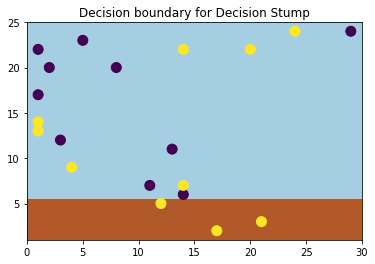

In [636]:
nb_points = 20
A = np.random.randint(1,30,(nb_points,2)).astype(float)
labels = np.random.choice(2,nb_points)
uni = 1./(nb_points)*np.ones(nb_points)
stump = myStump()
stump.learn(np.c_[A,labels],uni)
ax = plt.subplot(1,1,1)
plot_frontiere(stump,A,labels,ax)
plt.show()

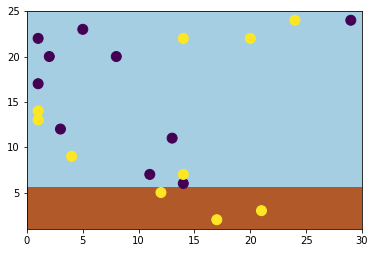

In [637]:
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(A,labels,sample_weight=uni)
ax = plt.subplot(1,1,1)
plot_frontiere(clf,A,labels,ax,naming=False)
plt.show()

In [622]:
my_stumps = []
for nb_points in range(30,250,50):
    A = np.random.randint(1,nb_points/2,(nb_points,2)).astype(float)
    labels = np.random.choice(2,nb_points)
    uni = 1./(nb_points)*np.ones(nb_points)
    stump = myStump()
    stump.learn(np.c_[A,labels],uni)
    my_stumps.append([stump, cross_valid_score(stump,np.c_[A,labels],distro=uni),A,labels])

In [624]:
sk_stumps = []
for (i,nb_points) in enumerate(range(30,250,50)):
    A = my_stumps[i][2]
    labels = my_stumps[i][3]
    uni = 1./(nb_points)*np.ones(nb_points)
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(A,labels)
    sk_stumps.append([clf, cross_valid_score(clf,np.c_[A,labels],distro=uni,sk=True),A,labels])

0
1
2
3
4


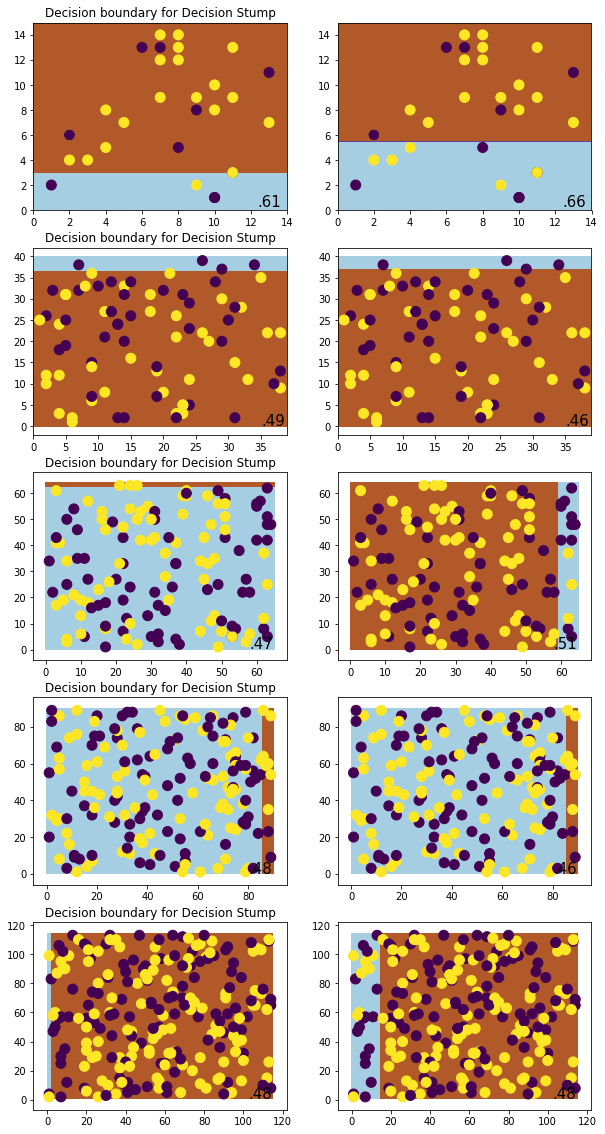

In [625]:
plt.figure(figsize=(10,20))
k = 1
for (i,(model,score,X,y)) in enumerate(my_stumps[:5]):
    print(i)
    ax = plt.subplot(len(my_stumps[:5]), 2, k)
    plot_frontiere(model, X, y, ax, score)
    ax = plt.subplot(len(my_stumps[:5]), 2, k+1)
    plot_frontiere(sk_stumps[i][0], X, y, ax, sk_stumps[i][1],naming=False)
    k += 2
#plt.tight_layout()
plt.show()

Our implementation is on the left, sklearn on the right.     
They behave in a similar way. Our implementation is **slower**, but we used $n^2$.    
They have comparable cross validations cores.

In [611]:
cross_valid_score(stump,np.c_[A,labels],uni)

0.55249999999999999

In [612]:
cross_valid_score(clf,np.c_[A,labels],uni,sk=True)

0.56250000000000011

# Annexes
## Routine de plot

In [472]:
def plot_frontiere(model, X, y, ax, extra=None, naming=True):
    h = .02 # grid step
    x_min= X[:, 0].min() - 1
    x_max= X[:, 0].max() + 1
    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z2d = model.predict(np.c_[xx.ravel(),yy.ravel()])
    Z2d=Z2d.reshape(xx.shape)
    if naming:
        ax.set_title("Decision boundary for "+model.name())
    ax.contourf(xx,yy,Z2d, cmap=plt.cm.Paired)
    ax.scatter(X[:,0],X[:,1], c = y, s = 100)
    if extra != None:
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % extra).lstrip('0'), size=15, horizontalalignment='right')
    return

# Routine de cross validation

In [594]:
# for cross val purpose
# sample is a matrix of labeled examples
def get_score_on(model, sample):
    prediction = model.predict(sample[:,:-1])
    labels = sample[:,-1:].squeeze()
    success = (prediction == labels).sum()
    return success/len(sample)

# Gives back a partion train/test
# with 40% test
def get_train_test(nb_examples):
    test = np.random.choice(nb_examples, int(nb_examples*0.4), replace=False)
    the_whole = set(range(0,nb_examples))
    train = list(the_whole-set(test))
    return train,test

# Computes the cross valid score
# of a model
def cross_valid_score(model, data, distro=None, sk=False, repeat=10):
    nb_examples = len(data)
    mean_score = 0.0
    for i in range(repeat):
        train_sample, test_sample = get_train_test(nb_examples)
        if not sk:
            model.learn(data[train_sample,:],p=False,distro=distro[train_sample]/distro[train_sample].sum())
        else:
            model.fit(data[train_sample,:-1],data[train_sample,-1].squeeze(),sample_weight=distro[train_sample]/distro[train_sample].sum())
        curr_score = get_score_on(model,data[test_sample,:])
        mean_score += curr_score
    mean_score /= repeat
    return mean_score